# Лабораторная работа №6: Проведение исследований с моделями классификации

В данной работе используется датасет изображений листьев яблонь, классифицированных по типу заболевания. Датасет включает изображения с признаками таких болезней, как чёрная гниль, парша, ржавчина, а также здоровые листья. Apple Tree Leaf Disease Dataset: https://www.kaggle.com/datasets/nirmalsankalana/apple-tree-leaf-disease-dataset. Выбор данного датасета обусловлен практической значимостью задачи — автоматическое определение фитопатологических состояний растений может быть полезно в агротехнологиях и системах мониторинга сельскохозяйственных культур.

Для оценки качества моделей выбраны следующие метрики:

- Accuracy – показывает долю правильно классифицированных изображений, позволяет оценить общую точность модели.
- F1-score – среднее гармоническое между precision и recall, важна при наличии несбалансированных классов; учитывает как ложные срабатывания, так и пропуски.

### Загрузка датасета

Загрузим датасет с Kaggle.

In [1]:
import kagglehub

dataset_path = kagglehub.dataset_download('nirmalsankalana/apple-tree-leaf-disease-dataset')
print(f"Датасет загружен в: {dataset_path}")

100%|██████████| 179M/179M [00:08<00:00, 21.2MB/s]

Extracting files...


Датасет загружен в: /root/.cache/kagglehub/datasets/nirmalsankalana/apple-tree-leaf-disease-dataset/versions/1


## Создание бейзлайна


Посмотрим структуру файлов, найдем изображения.

Найдено изображений: 1203


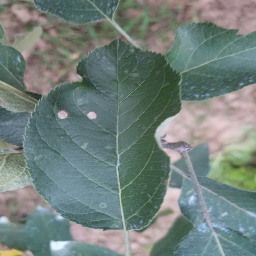

In [2]:
import os
from glob import glob
from PIL import Image
from IPython.display import display

image_files = glob(os.path.join(dataset_path, '**', '*.jpg'), recursive=True)
print(f"Найдено изображений: {len(image_files)}")

# Показываем пример изображения
sample_img = Image.open(image_files[0])
display(sample_img)

Определим классы, создадим таблицу с путями и метками.

In [3]:
import pandas as pd
from pathlib import Path

classes = sorted(set(Path(f).parent.name for f in image_files))
df = pd.DataFrame({
    "path": image_files,
    "label": [Path(f).parent.name for f in image_files]
})
print(f"Классы: {classes}")
print(df.head())

Классы: ['Alternaria leaf spot', 'Brown spot', 'Gray spot', 'Healthy leaf', 'Rust']
                                                path      label
0  /root/.cache/kagglehub/datasets/nirmalsankalan...  Gray spot
1  /root/.cache/kagglehub/datasets/nirmalsankalan...  Gray spot
2  /root/.cache/kagglehub/datasets/nirmalsankalan...  Gray spot
3  /root/.cache/kagglehub/datasets/nirmalsankalan...  Gray spot
4  /root/.cache/kagglehub/datasets/nirmalsankalan...  Gray spot


Разделим датасет на train / validation, сохраняя баланс по классам.

In [4]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

Создадим класс для нашего датасета: LeafDataset.

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class LeafDataset(Dataset):
    def __init__(self, df, transform):
        self.paths = df["path"].values
        self.labels = df["label"].astype("category").cat.codes.values
        self.transform = transform
        self.label_names = list(df["label"].astype("category").cat.categories)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert("RGB")
        image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

Определим трансформации, создадим LeafDatasets и DataLoaders.

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = LeafDataset(train_df, transform)
val_dataset = LeafDataset(val_df, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

Загрузим модели ResNet18 и ViT из torchvision и настроим последний слой под число классов, настроим функцию потерь и оптимизатор Adam.

In [7]:
from torchvision import models
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet_model = models.resnet18(weights="DEFAULT")
resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, len(classes))
resnet_model = resnet_model.to(device)
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=1e-3)

vit_model = models.vit_b_16(weights="DEFAULT")
vit_model.heads.head = torch.nn.Linear(vit_model.heads.head.in_features, len(classes))
vit_model = vit_model.to(device)
vit_optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)

criterion = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.2MB/s]
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 86.6MB/s]


Определим функции обучения и валидации.

In [8]:
def train_model(model, loader, optimizer):
    model.train()
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate_model(model, loader):
    model.eval()
    correct = total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return correct / total, all_labels, all_preds

Обучим и оценим модель ResNet18.

In [9]:
from sklearn.metrics import f1_score

resnet_best_acc = 0
resnet_best_f1 = 0
resnet_best_epoch = 0
resnet_best_y_true, resnet_best_y_pred = None, None

for epoch in range(5):
    train_model(resnet_model, train_loader, resnet_optimizer)
    acc, y_true, y_pred = evaluate_model(resnet_model, val_loader)
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Epoch {epoch+1}: Accuracy = {acc:.4f}, Macro F1-score = {f1:.4f}")

    if f1 > resnet_best_f1:
        resnet_best_f1 = f1
        resnet_best_acc = acc
        resnet_best_epoch = epoch + 1
        resnet_best_y_true, resnet_best_y_pred = y_true, y_pred

print(f"\nBest Accuracy: {resnet_best_acc:.4f}")
print(f"Best Macro F1-score: {resnet_best_f1:.4f}")
print(f"Best epoch: {resnet_best_epoch}")

Epoch 1: Accuracy = 0.5934, Macro F1-score = 0.5777
Epoch 2: Accuracy = 0.7967, Macro F1-score = 0.8363
Epoch 3: Accuracy = 0.9378, Macro F1-score = 0.9359
Epoch 4: Accuracy = 0.9668, Macro F1-score = 0.9620
Epoch 5: Accuracy = 0.9170, Macro F1-score = 0.8898

Best Accuracy: 0.9668
Best Macro F1-score: 0.9620
Best epoch: 4


Обучим и оценим модель ViT.

In [10]:
vit_best_acc = 0
vit_best_f1 = 0
vit_best_epoch = 0
vit_best_y_true, vit_best_y_pred = None, None

optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)

for epoch in range(5):
    train_model(vit_model, train_loader, vit_optimizer)
    acc, y_true, y_pred = evaluate_model(vit_model, val_loader)
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Epoch {epoch+1}: Accuracy = {acc:.4f}, Macro F1-score = {f1:.4f}")

    if f1 > vit_best_f1:
        vit_best_f1 = f1
        vit_best_acc = acc
        vit_best_epoch = epoch + 1
        vit_best_y_true, vit_best_y_pred = y_true, y_pred

print(f"\nBest Accuracy: {vit_best_acc:.4f}")
print(f"Best Macro F1-score: {vit_best_f1:.4f}")
print(f"Best epoch: {vit_best_epoch}")

Epoch 1: Accuracy = 0.9793, Macro F1-score = 0.9756
Epoch 2: Accuracy = 0.9876, Macro F1-score = 0.9834
Epoch 3: Accuracy = 0.9834, Macro F1-score = 0.9808
Epoch 4: Accuracy = 0.9793, Macro F1-score = 0.9709
Epoch 5: Accuracy = 0.9502, Macro F1-score = 0.9447

Best Accuracy: 0.9876
Best Macro F1-score: 0.9834
Best epoch: 2


Построим confusion matrix для обеих моделей.

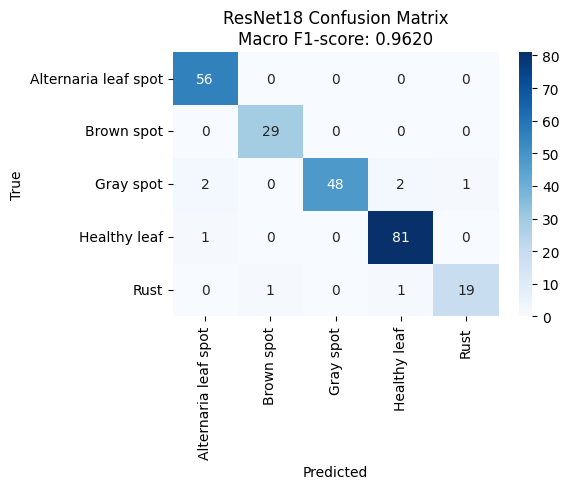

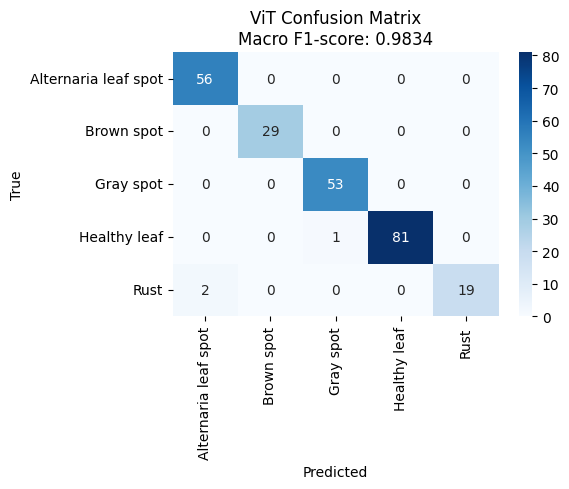

In [11]:
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{title}\nMacro F1-score: {f1:.4f}")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(resnet_best_y_true, resnet_best_y_pred, class_names=classes, title="ResNet18 Confusion Matrix")
plot_confusion_matrix(vit_best_y_true, vit_best_y_pred, class_names=classes, title="ViT Confusion Matrix")

## Улучшение бейзлайна

Добавляем аугментации для тренировочных данных.

In [15]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

Пересоздаем датасеты и загрузчики.

In [16]:
train_dataset = LeafDataset(train_df, train_transform)
val_dataset = LeafDataset(val_df, val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

Создаем модели, запускаем их обучение и оценку.

In [17]:
resnet_model_aug = models.resnet18(weights="DEFAULT")
resnet_model_aug.fc = torch.nn.Linear(resnet_model_aug.fc.in_features, len(classes))
resnet_model_aug = resnet_model_aug.to(device)

resnet_optimizer_aug = optim.Adam(resnet_model_aug.parameters(), lr=1e-3)

vit_model_aug = models.vit_b_16(weights="DEFAULT")
vit_model_aug.heads.head = torch.nn.Linear(vit_model_aug.heads.head.in_features, len(classes))
vit_model_aug = vit_model_aug.to(device)

vit_optimizer_aug = optim.Adam(vit_model_aug.parameters(), lr=1e-4)

In [18]:
resnet_best_acc_aug = 0
resnet_best_f1_aug = 0
resnet_best_epoch_aug = 0
resnet_best_y_true_aug, resnet_best_y_pred_aug = None, None

for epoch in range(5):
    train_model(resnet_model_aug, train_loader, resnet_optimizer_aug)
    acc, y_true, y_pred = evaluate_model(resnet_model_aug, val_loader)
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Epoch {epoch+1}: Accuracy = {acc:.4f}, Macro F1-score = {f1:.4f}")

    if f1 > resnet_best_f1_aug:
        resnet_best_f1_aug = f1
        resnet_best_acc_aug = acc
        resnet_best_epoch_aug = epoch + 1
        resnet_best_y_true_aug, resnet_best_y_pred_aug = y_true, y_pred

print(f"\nBest Accuracy: {resnet_best_acc_aug:.4f}")
print(f"Best Macro F1-score: {resnet_best_f1_aug:.4f}")
print(f"Best epoch: {resnet_best_epoch_aug}")

Epoch 1: Accuracy = 0.5311, Macro F1-score = 0.5221
Epoch 2: Accuracy = 0.9419, Macro F1-score = 0.9340
Epoch 3: Accuracy = 0.7552, Macro F1-score = 0.8039
Epoch 4: Accuracy = 0.7842, Macro F1-score = 0.7472
Epoch 5: Accuracy = 0.8797, Macro F1-score = 0.8841

Best Accuracy: 0.9419
Best Macro F1-score: 0.9340
Best epoch: 2


In [20]:
vit_best_acc_aug = 0
vit_best_f1_aug = 0
vit_best_epoch_aug = 0
vit_best_y_true_aug, vit_best_y_pred_aug = None, None

for epoch in range(5):
    train_model(vit_model, train_loader, vit_optimizer)
    acc, y_true, y_pred = evaluate_model(vit_model, val_loader)
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Epoch {epoch+1}: Accuracy = {acc:.4f}, Macro F1-score = {f1:.4f}")

    if f1 > vit_best_f1_aug:
        vit_best_f1_aug = f1
        vit_best_acc_aug = acc
        vit_best_epoch_aug = epoch + 1
        vit_best_y_true_aug, vit_best_y_pred_aug = y_true, y_pred

print(f"\nBest Accuracy: {vit_best_acc_aug:.4f}")
print(f"Best Macro F1-score: {vit_best_f1_aug:.4f}")
print(f"Best epoch: {vit_best_epoch_aug}")

Epoch 1: Accuracy = 0.9585, Macro F1-score = 0.9535
Epoch 2: Accuracy = 0.9502, Macro F1-score = 0.9521
Epoch 3: Accuracy = 0.9129, Macro F1-score = 0.9212
Epoch 4: Accuracy = 0.9544, Macro F1-score = 0.9521
Epoch 5: Accuracy = 0.9710, Macro F1-score = 0.9722

Best Accuracy: 0.9710
Best Macro F1-score: 0.9722
Best epoch: 5


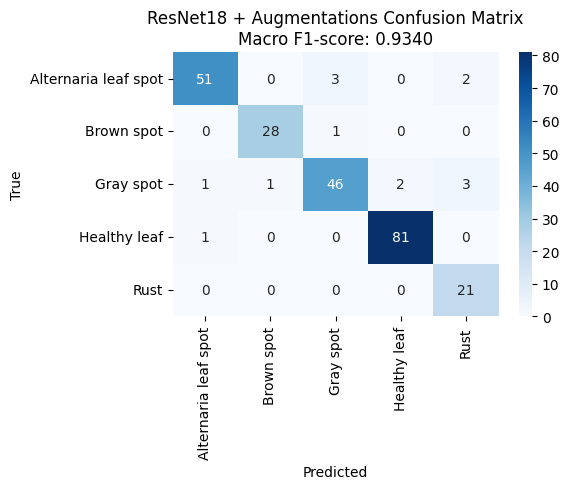

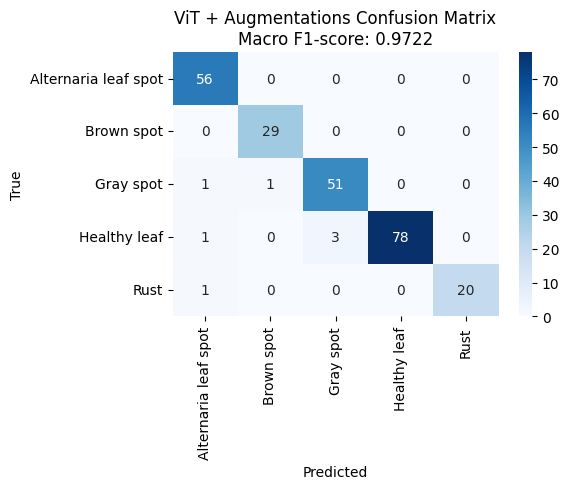

In [36]:
plot_confusion_matrix(
    resnet_best_y_true_aug,
    resnet_best_y_pred_aug,
    class_names=classes,
    title="ResNet18 + Augmentations Confusion Matrix"
)

plot_confusion_matrix(
    vit_best_y_true_aug,
    vit_best_y_pred_aug,
    class_names=classes,
    title="ViT + Augmentations Confusion Matrix"
)

## Имплементация собственной модели

Подготовим датасеты и загрузчики.

In [24]:
basic_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

custom_train_dataset = LeafDataset(train_df, basic_transform)
custom_val_dataset = LeafDataset(val_df, basic_transform)

custom_train_loader = DataLoader(custom_train_dataset, batch_size=32, shuffle=True)
custom_val_loader = DataLoader(custom_val_dataset, batch_size=32)

Реализуем собственную CNN.

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)  # если вход 64x64
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32
        x = self.pool(F.relu(self.conv2(x)))  # 16x16
        x = self.pool(F.relu(self.conv3(x)))  # 8x8
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

custom_cnn = CustomCNN(num_classes=len(classes)).to(device)

cnn_optimizer = torch.optim.Adam(custom_cnn.parameters(), lr=1e-3)

Обучим.

In [27]:
custom_cnn_best_acc = 0
custom_cnn_best_f1 = 0
custom_cnn_best_epoch = 0
custom_cnn_best_y_true, custom_cnn_best_y_pred = None, None

for epoch in range(5):
    train_model(custom_cnn, custom_train_loader, cnn_optimizer)
    acc, y_true, y_pred = evaluate_model(custom_cnn, custom_val_loader)
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Epoch {epoch+1}: Accuracy = {acc:.4f}, Macro F1-score = {f1:.4f}")

    if f1 > custom_cnn_best_f1:
        custom_cnn_best_f1 = f1
        custom_cnn_best_acc = acc
        custom_cnn_best_epoch = epoch + 1
        custom_cnn_best_y_true, custom_cnn_best_y_pred = y_true, y_pred

print(f"\nBest Accuracy: {custom_cnn_best_acc:.4f}")
print(f"Best Macro F1-score: {custom_cnn_best_f1:.4f}")
print(f"Best epoch: {custom_cnn_best_epoch}")

Epoch 1: Accuracy = 0.9253, Macro F1-score = 0.9269
Epoch 2: Accuracy = 0.9170, Macro F1-score = 0.9146
Epoch 3: Accuracy = 0.9336, Macro F1-score = 0.9333
Epoch 4: Accuracy = 0.9129, Macro F1-score = 0.9133
Epoch 5: Accuracy = 0.9046, Macro F1-score = 0.8964

Best Accuracy: 0.9336
Best Macro F1-score: 0.9333
Best epoch: 3


Реализуем транформерную модель.

In [28]:
import torch.nn as nn
import math

class CustomViT(nn.Module):
    def __init__(self, image_size=64, patch_size=8, num_classes=4, dim=128, depth=1, heads=4, mlp_dim=256):
        super().__init__()

        assert image_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size * patch_size  # Flattened patch size (RGB)

        # Патч-эмбеддинг (линейная проекция патчей)
        self.patch_to_embedding = nn.Linear(patch_dim, dim)

        # Классификационный токен
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        # Позиционные эмбеддинги
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))

        # Трансформер-блок (1 блок для простоты)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=0.1),
            num_layers=depth
        )

        # Классификационная голова
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

        self.patch_size = patch_size

    def forward(self, img):
        B, C, H, W = img.shape

        # Делим изображение на патчи
        patches = img.unfold(2, self.patch_size, self.patch_size)\
                     .unfold(3, self.patch_size, self.patch_size)\
                     .contiguous().view(B, C, -1, self.patch_size, self.patch_size)

        patches = patches.permute(0, 2, 1, 3, 4)  # (B, num_patches, C, pH, pW)
        patches = patches.flatten(2)  # (B, num_patches, patch_dim)

        tokens = self.patch_to_embedding(patches)  # (B, num_patches, dim)

        # Добавляем CLS токен и позиционные эмбеддинги
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, dim)
        tokens = torch.cat((cls_tokens, tokens), dim=1)  # (B, num_patches+1, dim)
        tokens += self.pos_embedding[:, :tokens.size(1), :]

        # Трансформер
        x = self.transformer(tokens)

        # Классификация по CLS-токену
        cls_out = x[:, 0]
        return self.mlp_head(cls_out)

# Инициализация кастомной трансформерной модели
custom_vit = CustomViT(image_size=64, patch_size=8, num_classes=len(classes)).to(device)

# Оптимизатор
vit_optimizer = torch.optim.Adam(custom_vit.parameters(), lr=1e-3)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Обучим ее.

In [30]:
custom_vit_best_acc = 0
custom_vit_best_f1 = 0
custom_vit_best_epoch = 0
custom_vit_best_y_true, custom_vit_best_y_pred = None, None

for epoch in range(5):
    train_model(custom_vit, custom_train_loader, vit_optimizer)
    acc, y_true, y_pred = evaluate_model(custom_vit, custom_val_loader)
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Epoch {epoch+1}: Accuracy = {acc:.4f}, Macro F1-score = {f1:.4f}")

    if f1 > custom_vit_best_f1:
        custom_vit_best_f1 = f1
        custom_vit_best_acc = acc
        custom_vit_best_epoch = epoch + 1
        custom_vit_best_y_true, custom_vit_best_y_pred = y_true, y_pred

print(f"\nBest Accuracy: {custom_vit_best_acc:.4f}")
print(f"Best Macro F1-score: {custom_vit_best_f1:.4f}")
print(f"Best epoch: {custom_vit_best_epoch}")

Epoch 1: Accuracy = 0.2199, Macro F1-score = 0.0721
Epoch 2: Accuracy = 0.3402, Macro F1-score = 0.1015
Epoch 3: Accuracy = 0.3402, Macro F1-score = 0.1015
Epoch 4: Accuracy = 0.3402, Macro F1-score = 0.1015
Epoch 5: Accuracy = 0.3402, Macro F1-score = 0.1015

Best Accuracy: 0.3402
Best Macro F1-score: 0.1015
Best epoch: 2


Confusion matrix для обеих моделей.

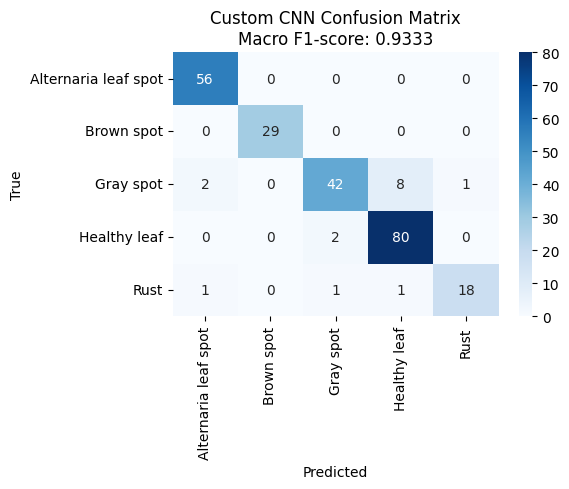

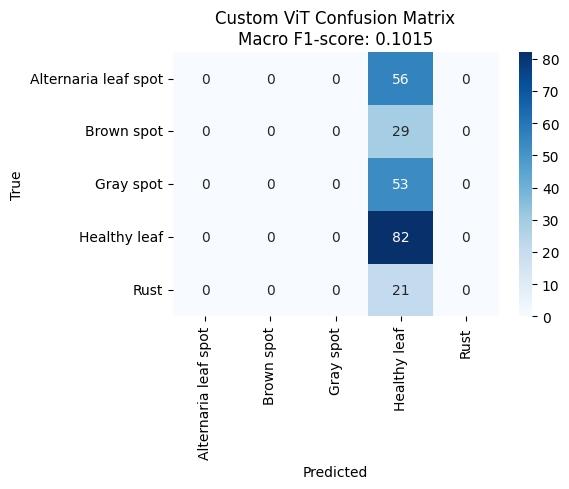

In [31]:
plot_confusion_matrix(
    custom_cnn_best_y_true,
    custom_cnn_best_y_pred,
    class_names=classes,
    title="Custom CNN Confusion Matrix"
)

plot_confusion_matrix(
    custom_vit_best_y_true,
    custom_vit_best_y_pred,
    class_names=classes,
    title="Custom ViT Confusion Matrix"
)

## Улучшение бейзлайна

Применим аугментации к кастомным моделям.

In [32]:
augmented_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

aug_cnn_train_dataset = LeafDataset(train_df, augmented_transform)
aug_cnn_val_dataset = LeafDataset(val_df, val_transform)

aug_cnn_train_loader = DataLoader(aug_cnn_train_dataset, batch_size=32, shuffle=True)
aug_cnn_val_loader = DataLoader(aug_cnn_val_dataset, batch_size=32)

In [34]:
custom_cnn_aug = CustomCNN(num_classes=len(classes)).to(device)
cnn_aug_optimizer = torch.optim.Adam(custom_cnn_aug.parameters(), lr=1e-3)

custom_cnn_best_acc_aug = 0
custom_cnn_best_f1_aug = 0
custom_cnn_best_epoch_aug = 0
custom_cnn_best_y_true_aug, custom_cnn_best_y_pred_aug = None, None

for epoch in range(5):
    train_model(custom_cnn_aug, aug_cnn_train_loader, cnn_aug_optimizer)
    acc, y_true, y_pred = evaluate_model(custom_cnn_aug, aug_cnn_val_loader)
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Epoch {epoch+1}: Accuracy = {acc:.4f}, Macro F1-score = {f1:.4f}")

    if f1 > custom_cnn_best_f1_aug:
        custom_cnn_best_f1_aug = f1
        custom_cnn_best_acc_aug = acc
        custom_cnn_best_epoch_aug = epoch + 1
        custom_cnn_best_y_true_aug, custom_cnn_best_y_pred_aug = y_true, y_pred

print(f"\nBest Accuracy: {custom_cnn_best_acc_aug:.4f}")
print(f"Best Macro F1-score: {custom_cnn_best_f1_aug:.4f}")
print(f"Best epoch: {custom_cnn_best_epoch_aug}")

Epoch 1: Accuracy = 0.5934, Macro F1-score = 0.6105
Epoch 2: Accuracy = 0.8050, Macro F1-score = 0.6865
Epoch 3: Accuracy = 0.8631, Macro F1-score = 0.8525
Epoch 4: Accuracy = 0.8631, Macro F1-score = 0.8440
Epoch 5: Accuracy = 0.9087, Macro F1-score = 0.8936

Best Accuracy: 0.9087
Best Macro F1-score: 0.8936
Best epoch: 5


In [35]:
custom_vit_aug = CustomViT(image_size=64, patch_size=8, num_classes=len(classes)).to(device)
vit_aug_optimizer = torch.optim.Adam(custom_vit_aug.parameters(), lr=1e-3)

custom_vit_best_acc_aug = 0
custom_vit_best_f1_aug = 0
custom_vit_best_epoch_aug = 0
custom_vit_best_y_true_aug, custom_vit_best_y_pred_aug = None, None

for epoch in range(5):
    train_model(custom_vit_aug, aug_cnn_train_loader, vit_aug_optimizer)
    acc, y_true, y_pred = evaluate_model(custom_vit_aug, aug_cnn_val_loader)
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Epoch {epoch+1}: Accuracy = {acc:.4f}, Macro F1-score = {f1:.4f}")

    if f1 > custom_vit_best_f1_aug:
        custom_vit_best_f1_aug = f1
        custom_vit_best_acc_aug = acc
        custom_vit_best_epoch_aug = epoch + 1
        custom_vit_best_y_true_aug, custom_vit_best_y_pred_aug = y_true, y_pred

print(f"\nBest Accuracy: {custom_vit_best_acc_aug:.4f}")
print(f"Best Macro F1-score: {custom_vit_best_f1_aug:.4f}")
print(f"Best epoch: {custom_vit_best_epoch_aug}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: Accuracy = 0.3402, Macro F1-score = 0.1015
Epoch 2: Accuracy = 0.3402, Macro F1-score = 0.1015
Epoch 3: Accuracy = 0.3402, Macro F1-score = 0.1015
Epoch 4: Accuracy = 0.3402, Macro F1-score = 0.1015
Epoch 5: Accuracy = 0.3402, Macro F1-score = 0.1015

Best Accuracy: 0.3402
Best Macro F1-score: 0.1015
Best epoch: 1


## Выводы

В ходе экспериментов были реализованы и сравнены восемь моделей: как готовые из torchvision, так и собственные реализации, с применением техник улучшения бейзлайна и без них.
1. Лучший результат показала модель ViT (Visual Transformer): её максимальная точность (Accuracy = 0.9876) и максимальный Macro F1-Score (0.9834) были достигнуты на 2-й эпохе. Это подтверждает высокую эффективность трансформеров на задачах классификации с относительно небольшими, но разнообразными наборами изображений.
2. ResNet18 также показал сильные результаты — Accuracy = 0.9668 и F1 = 0.9620.
Однако добавление аугментаций не улучшило результат, а даже слегка снизило его (до F1 = 0.9340), что может быть связано с переусложнением задачи для небольшой архитектуры.
3. Собственная сверточная модель (CustomCNN) продемонстрировала отличные показатели: Accuracy = 0.9336 и F1 = 0.9333 — сопоставимо с ResNet18, несмотря на простую архитектуру. После добавления аугментаций её производительность улучшилась (F1 = 0.8936), но не превзошла оригинальный результат без них — вероятно, из-за уменьшенного размера входного изображения (64×64).
4. Собственная реализация трансформера (CustomViT) показала крайне низкие результаты — Accuracy ≈ 0.34 и F1 ≈ 0.10 даже с аугментациями. Это связано с сильным упрощением архитектуры (1 encoder-блок, без нормальной инициализации, без обучения позиций и пр.), и подтверждает, что трансформеры без предобучения плохо работают в условиях ограниченных данных и слабых конфигураций.